In [1]:
ENV["JULIA_CUDA_VERSION"]="11.4" 
ENV["JULIA_CUDA_USE_BINARYBUILDER"] = true 
using Distributed,CUDA, CMBLensing
@everywhere using CUDA
CUDA.devices()

CUDA.DeviceIterator() for 2 devices:
0. NVIDIA A100 80GB PCIe
1. NVIDIA A100 80GB PCIe

In [70]:
@show addprocs(length(CUDA.devices())-1)
@show workers()
CUDA.functional()

addprocs(length(CUDA.devices()) - 1) = [6]


true

In [73]:
@everywhere using CMBLensing, UnPack, CompositeStructs, JLD2, Distributions, ProgressMeter, DelimitedFiles,Random, MuseInference,
                    ComponentArrays, Distributed,  LinearAlgebra, Plots, Printf, ForwardDiff, Zygote, LaTeXStrings, Setfield, CUDA
@everywhere import CMBLensing: MAP_joint, corrify#, Hessian_logpdf_preconditioner #,∇θ_logLike
@everywhere import MuseInference:  UnTransformedθ, Transformedθ, peel, AD, logPriorθ,
                    logLike, delete, select, SimpleCovariance

In [74]:
pool=Distributed.WorkerPool(procs()) # Should get master GPU working too
CMBLensing.assign_GPU_workers(;use_master=true,remove_oversubscribed_workers=true)#, use_master=true)

┌ Info: Processes (2):
│  (myid = 1, host = spartan-gpgpu109.hpc.unimelb.edu.au, device = CuDevice(0): NVIDIA A100 80GB PCIe 7c542ddf))
└  (myid = 5, host = spartan-gpgpu109.hpc.unimelb.edu.au, device = CuDevice(1): NVIDIA A100 80GB PCIe 48d5109c))


### Set up map dims, $\theta$'s and masking(w/o pt src's)

In [77]:

 
###### Put fg_ds on Array for cpu's
storage = CuArray
################## Map/Cl parameters
θpix = 1.25#0.42943580147717575# 1.25 
Nside = 512 ; pol = :I ; T = Float64 
beamFWHM = 0

lmin_bpwrs_ϕ=100 ; lmax_bpwrs_ϕ=1000
nbins_ϕ = 10 ; log_edges = range(log(lmin_bpwrs_ϕ),log(lmax_bpwrs_ϕ), floor(Int,nbins_ϕ+1))
ℓedges_ϕ = T.(exp.(log_edges)) 

lmin_bpwrs_T=200 ; lmax_bpwrs_T=1500 
ℓedges_T = lmin_bpwrs_T:50:lmax_bpwrs_T ; nbins_T = length(ℓedges_T)-1


lmin_bpwrs_g = 900 ; lmax_bpwrs_g = 1500
ℓedges_g = lmin_bpwrs_g:200:lmax_bpwrs_g
nbins_g = length(ℓedges_g)-1
  

##################### Apod mask and MPF params
pixel_mask_kwargs = (;edge_padding_deg = 0.5, edge_rounding_deg = 1, apodization_deg = 1, num_ptsrcs = 0) # old apod mask
pixel_mask_kwargs2 = (;edge_padding_deg = 1.5, edge_rounding_deg = 1, apodization_deg = 1, num_ptsrcs = 0)
dℓ=50
MPF_min = 100
MPF_max=1600
bandpass_mask = MidPass(MPF_min,MPF_max; Δℓ=dℓ);


ℓcenters_ϕ = (ℓedges_ϕ[2:end] + ℓedges_ϕ[1:end-1])/2 
ℓcenters_T = (ℓedges_T[2:end] + ℓedges_T[1:end-1])/2 
ℓcenters_g = (ℓedges_g[2:end] + ℓedges_g[1:end-1])/2 ;

In [78]:
512*1.25/60

10.666666666666666

### Check overlap of maps

The 36 maps are azimuthally spaced by 10$^{\circ}$, but the maps are $N_{pix}*\theta_{pix}$ = 512*1.25\/60 = 10$\frac{2}{3}^{\circ}$ wide

So there's a $\frac{2}{3}^{\circ}$ overlap on each side of a map

In [10]:
npix1_edge_pad=Int(0.5*60 / 1.25)
npix2_edge_pad=Int(1*60 / 1.25)

npix1_apod=Int(1.5*60 / 1.25)
npix2_apod=Int(2*60 / 1.25)

npix_overlap=Int((512*1.25 - 10*60)/1.25)

32

fmap = 0.43637043f0
fmap2 = 0.7237792f0
fmap2 / fmap = 1.6586348f0


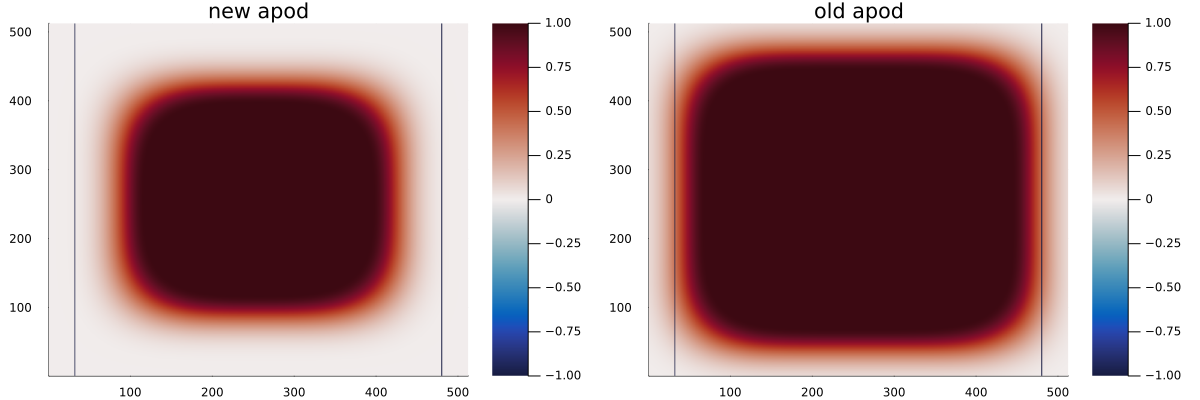

In [11]:
pixel_mask= make_mask( Nside, θpix; pixel_mask_kwargs...) #Diagonal(make_mask( Nside, θpix; pixel_mask_kwargs...).Ix, proj)
pixel_mask2= make_mask( Nside, θpix; pixel_mask_kwargs2...) #Diagonal(make_mask( Nside, θpix; pixel_mask_kwargs...).Ix, proj)

fmap = sum(pixel_mask.arr)/(512^2)
fmap2 = sum(pixel_mask2.arr)/(512^2)
@show fmap 
@show fmap2
@show fmap2/fmap 

check1 = copy(pixel_mask.arr) ; check1[1:end,npix_overlap] .= -1 ; check1[1:end,end-npix_overlap] .= -1
check2 = copy(pixel_mask2.arr) ;  check2[1:end,npix_overlap] .= -1 ; check2[1:end,end-npix_overlap] .= -1
mask_slice = pixel_mask.arr[1:end,npix_overlap]
mask_slice2 = pixel_mask2.arr[1:end,npix_overlap]

p1=heatmap(cpu(check1),c=:balance, clims=(-1,1),title="old apod")
p2=heatmap(cpu(check2),c=:balance, clims=(-1,1),title="new apod")


plot(p1,p2, size=(1200,400))


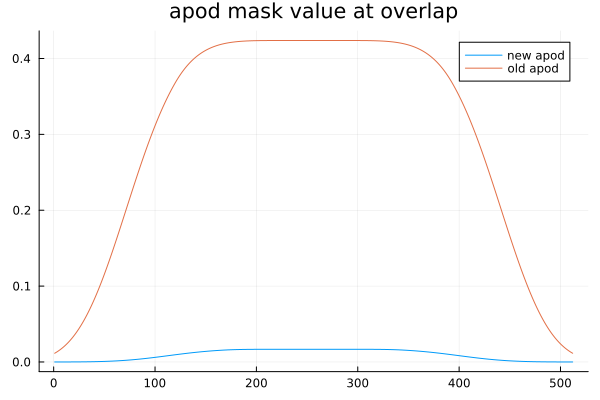

In [12]:

plot(mask_slice ,label="old apod",title="apod mask value at overlap")
plot!(mask_slice2,label="new apod")

### Theory $C_{\ell}$'s

In [79]:
############### Fiducial Cls
Cls = load_object("Input_Cls/yuuki_ini_camb_file__14_03_23_julia1p8p5.jld2")
# noise cls: Added to lensed T + g, so guaranteed true
Cℓn = load_object("Input_Cls/noise_cls_ilc_map_spt3gNoise_Nside512_1p25arminPix_20230106_jul1p8p5.jld2");
# Foreground-only Cℓs from full-sky map (nside 8192)
Cℓ_fg = load_object("Input_Cls/fg_only_Mkk_decoupled_Cls_FromNside8192Maps.jld2");

### Load the FGround dataset
If using $A_g, \alpha_g$...
$$
C_{\ell, \rm{fwd-model}}^{gg} = A_g*\Big{(}\frac{\ell}{\ell_{\rm{pivot}}}\Big{)}^{\alpha_g}
$$

... where the pivot, $\ell_{\rm{pivot}}$, is 1500 by default. 

In [81]:
############### foreground power spectrum shape parameters. Default is flat Cls
############### Alternatively, you can give load_fground_ds a particular spectrum shape with Cℓ_fg::Cℓs
Ag = Ag0 = 4.5e-6
αg = αg0 = 0.0
#ℓ_pivot=1500
############### foreground power spectrum shape parameters. Default is flat Cls

seed=0
rng=MersenneTwister(seed)
# save kwargs here so we can reload a slightly tweaked ds if needed
ds_kwargs = (;θpix, Nside, pol, storage,
    beamFWHM, Cℓ=Cls, Cℓn, bandpass_mask, pixel_mask_kwargs,
    rng, T, ℓedges_ϕ, ℓedges_T,
    ℓedges_g, L = LenseFlow(15), σ²κ=1f-8,
    Cℓ_fg,  # <------ Use full-sky Cls of foreground only map in fwd-model 
    #Ag, αg, ℓ_pivot # <------ Use flat Cls at best-fit Ag, αg values in fwd-model. (4.5e-6, 0 at ℓ_pivot=1500) 
)

@unpack ds, proj = load_fground_ds(; ds_kwargs...);

# Add SSP
ds.logprior = CMBLensing.logprior
apod_mask = ds.M.Y
fourier_mask=ds.M.X;

#### Masks

In [82]:
### Nside 512 source mask(s)
source_mask_orig = load_object("data_and_masks/mask_RA0degDECm57p5deg_Nside512_CIBRad4mJyPtsrc_ClusterMask3e14Msol_mdpl2_sims_srini_maps_20230801.jld2")
mask_patches = load_object("data_and_masks/ilc_mask_cut_folder__20230801/ilc_mask_cut_list__20230801.jld2")

## 22/02/23
# ILC of correctly masked component maps still have non-zero values in mask holes
# Hence ILC data remasked for sources, so give model Msrc^2
#source_mask = source_mask_orig*source_mask_orig
#source_mask=gpu(Diagonal(source_mask));
#pixel_mask = apod_mask*source_mask;

################## 01/08/23      NB!!!!!!!!!!!!
################# Remade ILC due to downgrading issue. The new map still has non-zero values in mask holes
################# as in the above, but the new map has NOT been remasked

source_mask=gpu(Diagonal(source_mask_orig*source_mask_orig));
pixel_mask = apod_mask*source_mask;
ds.M = fourier_mask*pixel_mask
ds.Mborder = pixel_mask ;
;

### Maps

In [83]:
########### Load up ilc data and apply full mask

############# Nside 512 data
# Singly src masked map 
ilc_signal_only_data = gpu(load_object("data_and_masks/mvilc_map__RA0degDECm57p5deg_Nside512_SinglyMasked_SignalOnly_spt3g1920Noiseweights_20230801.jld2"))
                                                                                                                    # ^^^^^^^^^^^^^^^^^^^ #
                                                                                                                    # means these noise levels were used in calculating ILC weights
# Remasked map
ilc_signal_only_data = gpu(Diagonal(source_mask_orig))*ilc_signal_only_data

# Singly src masked map patches
data_patches=load_object("data_and_masks/SinglySrcMasked_ilc_map_cut_list__20230801.jld2")
# Remasked map list
data_patches = mask_patches .* data_patches


###### Singly src masked Foreground only maps
###### fg only maps at 90/150/220 are combined with the ILC weights used to produce the above ilc maps
#fg_signal_only_data = gpu(load_object("data_and_masks/fg_only_map_cut_RA0degDECm57p5deg_Nside512_SinglyMasked_SignalOnly_spt3g1920Noiseweights_20230810.jld2"))
#fg_signal_only_data = gpu(Diagonal(source_mask_orig))*fg_signal_only_data
##
#data_patches=load_object("data_and_masks/fg_only_map_cuts_mdpl2_v0p7_bahamas80_scal1p000__20230809/fg_only_map_cut_list__20230810.jld2")
#data_patches=mask_patches .* data_patches


###### lensed cmb map patches. Note that we only have lensed T maps matching "data patches" above, but not the patch at RA0 DEC-57.5
cmb_95GHz_map_cut_list = load_object("data_and_masks/95GHz_map_cuts_MPF/cmb_map_cut_list_95GHz_MPFiltered.jld2")



###### kappa maps for cross-cor with data MAPs
kappa =  gpu(load_object("data_and_masks/kappa_map_cuts_mdpl2_v0p7_bahamas80_scal1p000/kappa_map_cut_RA0DECm57p5.jld2"))
kappa_patches =  gpu.(load_object("data_and_masks/kappa_map_cuts_mdpl2_v0p7_bahamas80_scal1p000/kappa_map_cut_list__20230810.jld2"))
# We'll be looking at data patches + the RA0 DEC-57.5 map altogether after MAPs have been loaded
pushfirst!(kappa_patches, kappa)




noise = gpu(simulate(MersenneTwister(0),ds.Cn))
### apodize ILC data : Note that ilc data may have been source masked
###                    so it may be unwise to beam the data until we have  unmasked 
###                    maps to work with
data_in = Map(fourier_mask*apod_mask*ds.B*ilc_signal_only_data) .+ Map(noise)
#data_in = Map(fourier_mask*apod_mask*ds.B*fg_signal_only_data) .+ Map(noise)

ds.d = gpu(data_in)

;

## Fwd-Model vs Data

In [15]:
cl_sims = @showprogress map(1:1000) do i
    get_Cℓ(simulate(MersenneTwister(i),ds).d).Cℓ
end
ls = get_Cℓ(data_in).ℓ

cl_sim = Cℓs(ls, mean(cl_sims));
σ_cl_sims = std(cl_sims);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


In [16]:
cl_ratio_sim2data_list=[]

data_cls_list = @showprogress map(data_patches, 1:length(data_patches)) do map_i, i
    noise_i = simulate(MersenneTwister(i), ds.Cn)
    M_i = fourier_mask*apod_mask # data_patches already src masked
    pwr=get_Cℓ(M_i*ds.B*gpu(map_i) + noise_i)
    push!(cl_ratio_sim2data_list, Cℓs(pwr.ℓ, cl_sim.Cℓ ./ pwr.Cℓ))
    pwr.Cℓ
end
avg_data_cls = Cℓs(ls, mean(data_cls_list));
σ_data_cls = std(data_cls_list);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


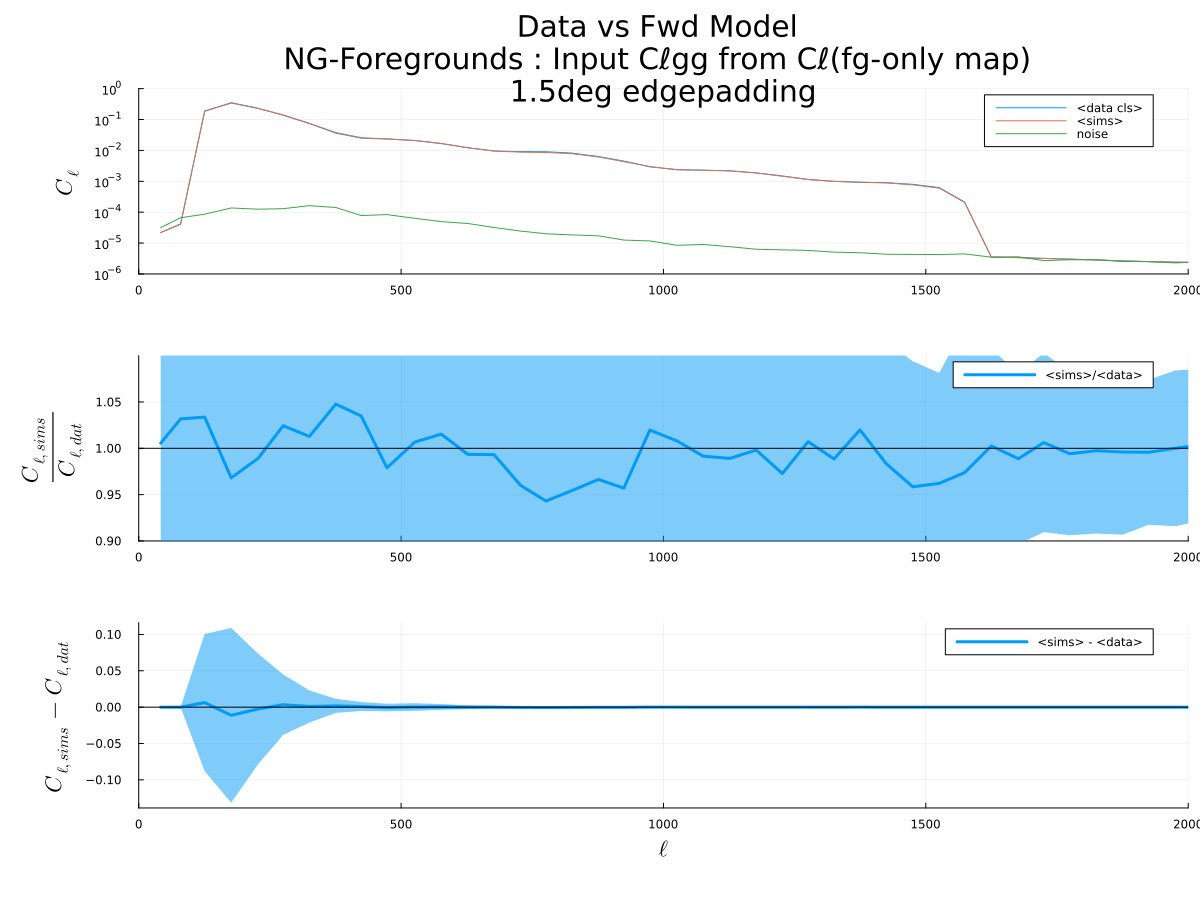

In [18]:
cl_ratio_sim2data_avg = cl_sim.Cℓ ./ avg_data_cls.Cℓ
σ_cl_ratio_sim2data_avg =@. cl_ratio_sim2data_avg * sqrt( (σ_cl_sims / cl_sim.Cℓ)^2 + (σ_data_cls / avg_data_cls.Cℓ)^2 )

cl_diff_sim2data_avg = cl_sim.Cℓ .- avg_data_cls.Cℓ
σ_cl_diff_sim2data_avg =@. sqrt( (σ_cl_sims)^2 + (σ_data_cls)^2 )

cl_ratio_sim2data = Cℓs(cl_sim.ℓ, cl_sim.Cℓ ./ get_Cℓ(ds.d).Cℓ)


#p1=plot(yscale=:log,title="Data vs Fwd Model \nNG-Foregrounds : Flat Input Cℓgg",titlefontsize=20)
p1=plot(yscale=:log,title="Data vs Fwd Model \nNG-Foregrounds : Input Cℓgg from Cℓ(fg-only map)",titlefontsize=20)
#p1=plot(yscale=:log,title="Foreground Model Mismatch\ndata=foreground-only maps\nsims=Flat Cℓgg at 'best fit' level",titlefontsize=20)

#plot!(get_Cℓ(ds.d),label="data cls : 1 map")
plot!(avg_data_cls,label="<data cls>")
#plot!(Cℓ_fg)
plot!(cl_sim,label="<sims>")
plot!(get_Cℓ(simulate(ds.Cn)),label="noise")
ylims!(1e-6,1)
#vline!(ℓedges_T,c="red",label="ℓedges_T",alpha=0.5)
ylabel!(L"C_{\ell}")#, fontsize=50)

p2 = plot()
plot!(cl_sim.ℓ,cl_ratio_sim2data_avg; ribbon=σ_cl_ratio_sim2data_avg,  label="<sims>/<data>",lw=3)
#map(cl_ratio_sim2data_list) do cl
#    plot!(cl,label="",alpha=0.3)
#end
ϵ=0.1
ylims!(1-ϵ, 1+ϵ)
#vline!(ℓedges_T,c="red",label="ℓedges_T",alpha=0.5)
hline!([1],c="black",label="")
ylabel!(L"\frac{C_{\ell, sims}}{C_{\ell, dat}}")


p3 = plot()
plot!(cl_sim.ℓ,cl_diff_sim2data_avg; ribbon=σ_cl_diff_sim2data_avg,  label="<sims> - <data>",lw=3)
#map(cl_diff_sim2data_list) do cl
#    plot!(cl,label="",alpha=0.3)
#end
ylabel!(L"C_{\ell, sims} - C_{\ell, dat}")
xlabel!(L"\ell")
hline!([0],c="black",label="")

p_tot=plot(p1,p2,p3,
    layout = (3,1), size=(1200,900), 
    xlims=(0,2000), left_margin=10Plots.mm,bottom_margin=10Plots.mm,
    xguidefontsize=15,yguidefontsize=15)

In [19]:
savefig(p_tot,"muse_bias_hunt_plots/Cl_Dat_vs_FwdMod_NGfg_1p5degEdgePad_inputClggTrue_lmax1600__All_3.png")

"/data/gpfs/projects/punim1801/muse/muse_bias_hunt_plots/Cl_Dat_vs_FwdMod_NGfg_1p5degEdgePad_inputClggTrue_lmax1600__All_3.png"

# SPECIFY RUN NUMBER!!!

In [84]:
RUN_NUMBER = 10.1

10.1

# Run # details
## Run 0.1, 9 and 10 are lensed-cmb only, NGfg data with flat $C_{\ell}^{gg}$ sim model and, NGfg data with $C_{\ell}^{gg}$ from full-sky foregrounds only ILC map (C$\ell$g in Theory C$\ell$'s above) as sim model.

### #0
#### Nside = 512
#### bandpass_mask = MidPass(100,4100; Δℓ=50)
#### $A_{g,0}$ = 0 $\mu K^2$
#### lensed CMB only run for sanity check

### #0.1
#### Nside = 512
#### bandpass_mask = MidPass(100,1600; Δℓ=50)
#### $A_{g,0}$ = 0 $\mu K^2$
#### lensed CMB only run for sanity check

---
## #9 
#### Nside = 512
#### bandpass_mask = MidPass(100,1600; Δℓ=50)
#### $A_{g,0}$ = 4.5e-6 $\mu K^2$

## #9.1 
#### Nside = 512
#### bandpass_mask = MidPass(100,1600; Δℓ=50)
#### $A_{g,0}$ = 4.5e-6 $\mu K^2$
#### data not remasked. => ds.M.Y = $\mathbb{M_{apod}}*\mathbb{M_{src}}$ instead of $\mathbb{M_{apod}}*\mathbb{M_{src}}^2$

---
## #10 
#### Nside = 512
#### bandpass_mask = MidPass(100,1600; Δℓ=50)
#### Use Full-Sky fg-only $C_{\ell}$'s as input foreground spectrum shape for forward model.
#### i.e. cheat
---

### $z_0, \theta_0$ and MAP_joint_kwargs

In [85]:
################# MUSE variables 
temp = simulate(MersenneTwister(1), ds)
z₀ = zero(LenseBasis(FieldTuple(;f=temp.f, ϕ=temp.ϕ, g=temp.g)))
θ₀ = ComponentVector(;Aϕ=ones(nbins_ϕ), AT=ones(nbins_T))#, Ag=ones(nbins_g))


MAPsteps=50
prior_deprojection_factor = 0.8
################# MAP variables
MAP_joint_kwargs=(;
    nsteps=MAPsteps, 
    progress=true, 
    aggressive_gc=true, 
    history_keys=(:logpdf,:∇Ω°_logpdf),#,:α,:f,:ϕ,:argmaxf_logpdf_history,:ΔΩ°), 
    conjgrad_kwargs=(progress=false, tol=1e-1, nsteps=2000),
    prior_deprojection_factor)
;

# First part of the notebook is getting MAPs for one data patch and 100 sims
### The MAPs for the other 36 patches and their respective sims are done after this section in Multi Patch MAPs 

### Do Data MAP

In [20]:
MAP_dat =  MAP_joint(θ₀, ds, FieldTuple(;ϕ=z₀.ϕ,g=z₀.g);
                            fstart=z₀.f,
                            MAP_joint_kwargs...
                            );

MAP_joint: 100%|████████████████████████████████████████| Time: 0:04:01
  step:        50
  logpdf:      5172756.39
  α:           0.013127725233706193
  CG:          75 iterations (1.77 sec)
  Linesearch:  8 bisections (0.40 sec)


In [21]:
######## Save Single MAP run ###################################
dir="approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/"
save_object(dir*"fJ_ilc_dat_σ²κ"*string(ds.σ²κ)*".jld2",cpu(MAP_dat.f))
save_object(dir*"ϕJ_ilc_dat_σ²κ"*string(ds.σ²κ)*".jld2",cpu(MAP_dat.ϕ))
save_object(dir*"gJ_ilc_dat_σ²κ"*string(ds.σ²κ)*".jld2",cpu(MAP_dat.g))


### Check SSP width effect. 

#### Ans: No effect for MidPass(100,1600; Δℓ=50) runs

In [99]:
SSP_width=[4,5,6,7,8]; SSP_width=10. .^-(SSP_width)

for σκ in SSP_width
    DS = load_fground_ds(;σ²κ=σκ, delete(ds_kwargs,:σ²κ)...);
    ds_tmp = DS.ds ; DS=nothing
    ds_tmp.M = fourier_mask*pixel_mask
    ds_tmp.Mborder = pixel_mask
    ds_tmp.d = gpu(data_in)
    MAP_dat =  MAP_joint(θ₀, ds_tmp, FieldTuple(;ϕ=z₀.ϕ,g=z₀.g);
                                fstart=z₀.f,
                                MAP_joint_kwargs...
                                );
    dir="approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/"
    save_object(dir*"fJ_ilc_dat_σ²κ"*string(σκ)*".jld2",cpu(MAP_dat.f))
    save_object(dir*"ϕJ_ilc_dat_σ²κ"*string(σκ)*".jld2",cpu(MAP_dat.ϕ))
    save_object(dir*"gJ_ilc_dat_σ²κ"*string(σκ)*".jld2",cpu(MAP_dat.g))
end

MAP_joint: 100%|████████████████████████████████████████| Time: 0:03:11
  step:        50
  logpdf:      4854535.16
  α:           0.022560828603229777
  CG:          154 iterations (2.99 sec)
  Linesearch:  5 bisections (0.29 sec)


In [100]:
cl_phis = map(SSP_width) do σκ
    ϕ = load_object(dir*"ϕJ_ilc_dat_σ²κ"*string(σκ)*".jld2")
    get_ℓ⁴Cℓ(ϕ1)
end;

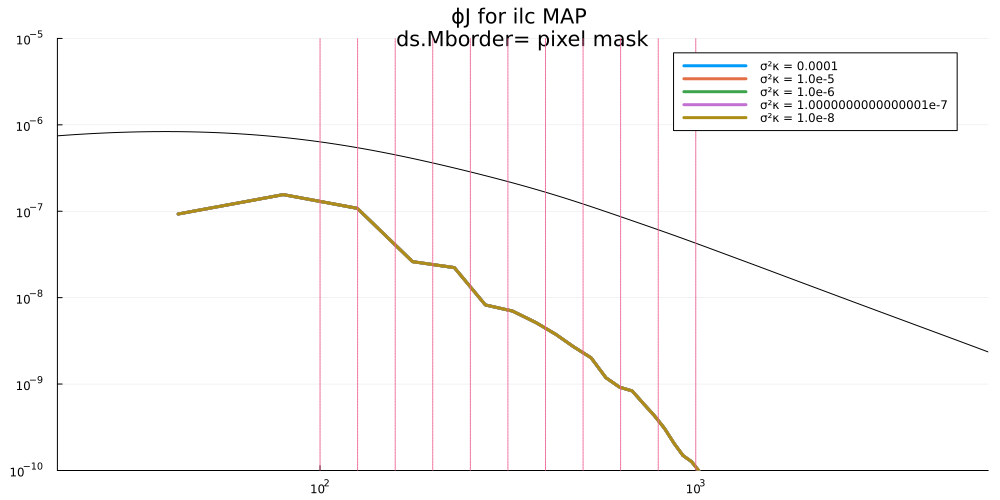

In [101]:
p=plot(yscale=:log10, xscale=:log10,title="ϕJ for ilc MAP \nds.Mborder= pixel mask",size=(1000,500))
map(cl_phis,SSP_width) do cl, σκ
    plot!(cl,lw=3, label=" σ²κ = "*string(σκ))
end
plot!(ℓ⁴*Cls.total.ϕϕ,color="black",label="")
vline!(ℓedges_ϕ, ls=:dot,label="")
xlims!(20,6e3)
ylims!(1e-10,1e-5)

### Do Sim MAPs

In [ ]:
Nsims = 100
Nstart = 10


dir="approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/gauss_fg_MAPs_M0/"
sim_scores = @showprogress pmap(pool, Nstart:1:Nsims) do i
#sim_scores = @showprogress pmap(pool, sim_seeds) do i
    sim_dat = simulate(MersenneTwister(i),ds).d
    MAP_sim =  MAP_joint(θ₀, @set(ds.d=sim_dat), FieldTuple(;ϕ=z₀.ϕ,g=z₀.g);
                                fstart=z₀.f,
                                progress=false,
                                delete(MAP_joint_kwargs,:progress)...
                                #MAP_joint_kwargs...
                                );
    save_object(dir*"fJ_GaussFg_σ²κ"*string(ds.σ²κ)*"_sim"*string(i)*".jld2",cpu(MAP_sim.f))
    save_object(dir*"ϕJ_GaussFg_σ²κ"*string(ds.σ²κ)*"_sim"*string(i)*".jld2",cpu(MAP_sim.ϕ))
    save_object(dir*"gJ_GaussFg_σ²κ"*string(ds.σ²κ)*"_sim"*string(i)*".jld2",cpu(MAP_sim.g))
    Cϕ_x_∇ϕ_logpdf_hist = []
    for (j,∇Ω°_logpdf) in enumerate(getindex.(MAP_sim.history,:∇Ω°_logpdf))
        push!(Cϕ_x_∇ϕ_logpdf_hist, cpu(get_Cℓ(ds.Cϕ * gpu(∇Ω°_logpdf.ϕ°))))
    end
    save_object(dir*"ΔlogP_σ²κ"*string(ds.σ²κ)*"_sim"*string(i)*".jld2",Cϕ_x_∇ϕ_logpdf_hist)
    save_object(dir*"logP_vs_MAPsteps_σ²κ"*string(ds.σ²κ)*"_sim"*string(i)*".jld2",cpu(getindex.(MAP_sim.history,:logpdf)))
    #sim_score = gradient(θ->logpdf(ds; d=sim_dat, delete(MAP_sim, :history)..., θ), θ₀)[1]
    #sim_score
    []
end
;

### Load data Score (M0)

In [87]:
####### M0 
dir="approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/"
f =  gpu(load_object(dir*"fJ_ilc_dat_σ²κ"*string(ds.σ²κ)*".jld2"))
ϕ =  gpu(load_object(dir*"ϕJ_ilc_dat_σ²κ"*string(ds.σ²κ)*".jld2"))
g =  gpu(load_object(dir*"gJ_ilc_dat_σ²κ"*string(ds.σ²κ)*".jld2"))

MAP_dat_M0 = (;f, ϕ, g)
dat_score = gradient(θ->logpdf(ds; MAP_dat_M0..., θ), θ₀)[1]

### Load Sim MAPs

In [ ]:
######### M0 sims
dir="approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/gauss_fg_MAPs_M0/"
#dir="approx_muse_maps/run5/base_sim_MAPs/"
MAP_sims_M0 = []

sim_scores = @showprogress map(1:100) do i
    sim_dat = simulate(MersenneTwister(i),ds).d
    f = gpu(load_object(dir*"fJ_GaussFg_σ²κ"*string(ds.σ²κ)*"_sim"*string(i)*".jld2"))
    ϕ = gpu(load_object(dir*"ϕJ_GaussFg_σ²κ"*string(ds.σ²κ)*"_sim"*string(i)*".jld2"))
    g = gpu(load_object(dir*"gJ_GaussFg_σ²κ"*string(ds.σ²κ)*"_sim"*string(i)*".jld2"))
    push!(MAP_sims_M0, (;f, ϕ, g) )

    sim_score = gradient(θ->logpdf(ds; d=sim_dat, f, ϕ, g, θ), θ₀)[1]
    sim_score
end
avg_sim_scores = mean(sim_scores);
;

In [ ]:
plot(get_Cℓ(simulate(ds.Cg)))
xlims!(0,5000)

## MAP checks

### Power Spectra

In [ ]:
sim_ϕ_pwr = []
start=1
fin = 100
sim_ϕ_pwr = @showprogress map( MAP_sims_M0[start:fin]) do  sim_MAP
    get_ℓ⁴Cℓ(sim_MAP.ϕ).Cℓ
end

ls = get_ℓ⁴Cℓ(MAP_dat.ϕ).ℓ
avg_sim_ϕ_pwr = Cℓs(ls,mean(sim_ϕ_pwr));

In [ ]:

p=plot(yscale=:log10, xscale=:log10,title="ϕJ for ilc MAP \nds.Mborder= pixel mask",size=(1000,500))
plot!(get_ℓ⁴Cℓ(MAP_dat_M0.ϕ),lw=3, label="ILC data map : σκ = "*string(ds.σ²κ))
plot!(avg_sim_ϕ_pwr,lw=3, label="<sim> power : σκ = "*string(ds.σ²κ))
plot!(ℓ⁴*Cls.total.ϕϕ,color="black",label="")
vline!(ℓedges_ϕ, ls=:dot,label="")
xlims!(20,6e3)
ylims!(1e-10,1e-5)

### $\kappa_J$

In [ ]:

lim=0.08

seed1 = 100
seed2 = 2
κJ_gauss1 = ∇²*-MAP_sims_M0[seed1].ϕ/2
κJ_gauss2 = ∇²*-MAP_sims_M0[seed2].ϕ/2

κ_true1 = ∇²*-simulate(MersenneTwister(seed1),ds).ϕ/2
κ_true2 = ∇²*-simulate(MersenneTwister(seed2),ds).ϕ/2
p1 = heatmap(cpu(Map(fourier_mask*κJ_gauss1).arr), color=:balance,title="GaussFG : seed"*string(seed1)*" \n σ²κ = "*string(ds.σ²κ),clims=(-lim,lim))
p2 = heatmap(cpu(Map(fourier_mask*κJ_gauss2).arr), color=:balance,title="GaussFG : seed"*string(seed2)*" \n σ²κ = "*string(ds.σ²κ),clims=(-lim,lim))
p3 = heatmap(cpu(Map(fourier_mask*κ_true1).arr),title="κ true : seed"*string(seed1)*" (gauss)", color=:balance, clims=(-2lim,2lim))
p4 = heatmap(cpu(Map(fourier_mask*κ_true2).arr),title="κ true : seed"*string(seed2)*" (gauss)", color=:balance, clims=(-2lim,2lim))

p=plot(p1,p2,p3,p4,size=(1000,800))

In [ ]:
MPF = Cℓ_to_Cov(:I, proj, MidPass(150,1000,Δℓ=50).diag.Wℓ ; units=1)
lim=0.08

κJ_dat = MPF*∇²*-MAP_dat.ϕ/2
κ_true_dat = MPF*kappa

p1 = heatmap(cpu(Map(fourier_mask*κJ_dat).arr), color=:balance,title="κJ_dat\n σ²κ = "*string(ds.σ²κ),clims=(-lim,lim))
p2 = heatmap(cpu(Map(fourier_mask*κ_true_dat).arr), color=:balance,title="κ_true_dat",clims=(-2lim,2lim))
p=plot(p1,p2,size=(1000,400))

### $\phi_J$

In [ ]:
# pixel map / Mborder
lim=1e-6

seed1 = 100
seed2 = 2
ϕJ_gauss1 = MAP_sims_M0[seed1].ϕ
ϕJ_gauss2 = MAP_sims_M0[seed2].ϕ

ϕ_true1 = simulate(MersenneTwister(seed1),ds).ϕ
ϕ_true2 = simulate(MersenneTwister(seed2),ds).ϕ
p1 = heatmap(cpu(Map(fourier_mask*ϕJ_gauss1).arr), color=:balance,title="GaussFG : seed"*string(seed1)*" \n σ²κ = "*string(ds.σ²κ),clims=(-lim,lim))
p2 = heatmap(cpu(Map(fourier_mask*ϕJ_gauss2).arr), color=:balance,title="GaussFG : seed"*string(seed2)*" \n σ²κ = "*string(ds.σ²κ),clims=(-lim,lim))
p3 = heatmap(cpu(Map(fourier_mask*ϕ_true1).arr),title="ϕ true : seed"*string(seed1)*" (gauss)", color=:balance, clims=(-2lim,2lim))
p4 = heatmap(cpu(Map(fourier_mask*ϕ_true2).arr),title="ϕ true : seed"*string(seed2)*" (gauss)", color=:balance, clims=(-2lim,2lim))

p=plot(p1,p2,p3,p4,size=(1000,800))

In [ ]:
MPF = Cℓ_to_Cov(:I, proj, MidPass(150,1000,Δℓ=50).diag.Wℓ ; units=1)
lim=1e-6

ϕJ_dat = MPF*MAP_dat.ϕ
ϕ_true_dat = MPF*(∇²\kappa*2)

p1 = heatmap(cpu(Map(fourier_mask*ϕJ_dat).arr), color=:balance,title="ϕJ_dat\n σ²κ = "*string(ds.σ²κ),clims=(-lim,lim))
p2 = heatmap(cpu(Map(fourier_mask*ϕ_true_dat).arr), color=:balance,title="ϕ_true_dat",clims=(-2lim,2lim))
p=plot(p1,p2,size=(1000,400))

### $f_J$

In [ ]:
# pixel map / Mborder
lim=300

seed1 = 100
seed2 = 2
fJ_gauss1 = MAP_sims_M0[seed1].f
fJ_gauss2 = MAP_sims_M0[seed2].f

f_true1 = simulate(MersenneTwister(seed1),ds).f
f_true2 = simulate(MersenneTwister(seed2),ds).f
p1 = heatmap(cpu(Map(fourier_mask*fJ_gauss1).arr), color=:balance,title="GaussFG : seed"*string(seed1)*" \n σ²κ = "*string(ds.σ²κ),clims=(-lim,lim))
p2 = heatmap(cpu(Map(fourier_mask*fJ_gauss2).arr), color=:balance,title="GaussFG : seed"*string(seed2)*" \n σ²κ = "*string(ds.σ²κ),clims=(-lim,lim))
p3 = heatmap(cpu(Map(fourier_mask*f_true1).arr),title="f true : seed"*string(seed1)*" (gauss)", color=:balance, clims=(-lim,lim))
p4 = heatmap(cpu(Map(fourier_mask*f_true2).arr),title="f true : seed"*string(seed2)*" (gauss)", color=:balance, clims=(-lim,lim))

p=plot(p1,p2,p3,p4,size=(1000,800))

### $g_J$

In [ ]:
# pixel map / Mborder
lim=0.3

seed1 = 100
seed2 = 2
gJ_gauss1 = MAP_sims_M0[seed1].g
gJ_gauss2 = MAP_sims_M0[seed2].g

g_true1 = simulate(MersenneTwister(seed1),ds).g
g_true2 = simulate(MersenneTwister(seed2),ds).g
p1 = heatmap(cpu(Map(fourier_mask*gJ_gauss1).arr), color=:balance,title="GaussFG : seed"*string(seed1)*" \n σ²κ = "*string(ds.σ²κ),clims=(-lim,lim))
p2 = heatmap(cpu(Map(fourier_mask*gJ_gauss2).arr), color=:balance,title="GaussFG : seed"*string(seed2)*" \n σ²κ = "*string(ds.σ²κ),clims=(-lim,lim))
p3 = heatmap(cpu(Map(fourier_mask*g_true1).arr),title="g true : seed"*string(seed1)*" (gauss)", color=:balance, clims=(-20lim,20lim))
p4 = heatmap(cpu(Map(fourier_mask*g_true2).arr),title="g true : seed"*string(seed2)*" (gauss)", color=:balance, clims=(-20lim,20lim))

p=plot(p1,p2,p3,p4,size=(1000,800))

### sim $\rho(\phi_{true},\phi_{MAP})$

In [ ]:
LPF = LowPass(1600)

ρϕs = [] ; Ls = nothing
ρfs = [] ; ℓs_f = nothing
ρgs = [] ; ℓs_g = nothing
@showprogress for seed in 1:100
    ϕJ_1 = MAP_sims_M0[seed].ϕ
    ϕ_true1 = simulate(gpu(MersenneTwister(seed)),ds).ϕ
    
    ρϕ1 = get_ρℓ(ϕJ_1, ϕ_true1)
    
    
    fJ_1 = MAP_sims_M0[seed].f
    f_true1 = LPF*simulate(MersenneTwister(seed),ds).f
    ρf1 = get_ρℓ(fJ_1, f_true1)
    
    gJ_1 = MAP_sims_M0[seed].g
    g_true1 = LPF*simulate(MersenneTwister(seed),ds).g
    
    ρg1 = get_ρℓ(gJ_1, g_true1)
    push!(ρϕs, ρϕ1.Cℓ)
    push!(ρfs, ρf1.Cℓ)
    push!(ρgs, ρg1.Cℓ)
    
    seed ==1 ? (Ls=ρϕ1.ℓ ; ℓs_f=ρf1.ℓ ; ℓs_g=ρg1.ℓ) : ()
end
σ_ρϕs = std(ρϕs)
σ_ρfs = std(ρfs)
σ_ρgs = std(ρgs)


;

In [ ]:

ϕJ = MAP_dat.ϕ
ρϕ_dat = get_ρℓ(0.5*∇²*ϕJ, kappa)
;

In [ ]:
#p1 = plot(xscale=:log10,xlims=(50,1500),title="NG-Foregrounds : Flat Input Cℓgg")
p1 = plot(xscale=:log10,xlims=(50,1500),title="NG-Foregrounds : True Input Cℓgg")
hline!([0],c="black",lw=0.5,label="")
xlabel!(L"L")
ylabel!(L"\rho_L(\phi_J, \phi_{true})")

p2= plot(xlims=(10,MPF_max))
hline!([0],c="black",lw=0.5,label="")
xlabel!(L"\ell")
ylabel!(L"\rho_{\ell}(f_J, f_{true})")

p3= plot(xlims=(10,MPF_max))
hline!([0],c="black",lw=0.5,label="")
xlabel!(L"\ell")
ylabel!(L"\rho_{\ell}(g_J, g_{true})")

plot!(p1, Cℓs(Ls, mean(ρϕs)), lw=4, c="black", ribbon = σ_ρϕs, label=L"\langle \rho \rangle|_{\rm{sims}}",fontsize=20)#,linealpha=0.1)#,seriesalpha=0.1)
plot!(p2, Cℓs(ℓs_f, mean(ρfs)), lw=4, c="black", ribbon = σ_ρfs, label=L"\langle \rho \rangle|_{\rm{sims}}",fontsize=20)
plot!(p3, Cℓs(ℓs_g, mean(ρgs)), lw=4, c="black", ribbon = σ_ρgs, label=L"\langle \rho \rangle|_{\rm{sims}}",fontsize=20)

plot!(p1, ρϕ_dat, lw=4, c="blue",  label=L"\rho_{\rm{dat}}")#,linealpha=0.1)#,seriesalpha=0.1)
#plot!(p2, Cℓs(ℓs_f, mean(ρfs_dats)), lw=4, c="blue", ribbon = σ_ρfs_dats, label=L"\langle \rho \rangle|_{\rm{dat}}")


ylims!(p1,0,1)
ylims!(p3,-0.3,0.4)
p_main=plot(p1,p2,p3, size=(1000,1000),layout=(3,1),legendfontsize=15,
            xguidefontsize=15,yguidefontsize=15, titlefontsize=20,
            left_margin=15Plots.mm, bottom_margin=15Plots.mm)

LoadError: UndefVarError: σ_ρϕs not defined

In [ ]:
savefig(p_main, "rho_fphig_NGfg_newApod_1dat_true_inputClgg_lmax1600.png")

LoadError: UndefVarError: p_main not defined

In [ ]:
RUN_NUMBER

### Scores

In [ ]:
flatten_exp=2

p1=plot(xscale=:log10, title="ILC scores : Aϕ", left_margin=5Plots.mm)#, ylims=(-2,4))
map(sim_scores) do sim_score_i
    plot!(ℓcenters_ϕ, sim_score_i.Aϕ ./ (ℓcenters_ϕ.^flatten_exp),label="", lw=0.5,ls=:dot)
end
plot!(ℓcenters_ϕ, dat_score.Aϕ ./(ℓcenters_ϕ.^flatten_exp),label="ilc s_dat : ϕ",lw=4,color="blue")
plot!(ℓcenters_ϕ,  avg_sim_scores.Aϕ ./(ℓcenters_ϕ.^flatten_exp),label="ilc <s_sims>: ϕ",lw=4,color="red")

ylabel!("score / (L^$(flatten_exp))")
xlabel!("L")

p2=plot(title="ILC scores : AT",legend=:bottomleft)#, ylims=(-2,4))
map(sim_scores) do sim_score_i
    plot!(ℓcenters_T, sim_score_i.AT,label="", lw=0.5,ls=:dot)
end
plot!(ℓcenters_T, dat_score.AT ,label="ilc s_dat : T",lw=4,color="blue")
plot!(ℓcenters_T,  avg_sim_scores.AT,label="ilc <s_sims>: T",lw=4,color="red")

p3=plot(title="ILC scores : Ag", left_margin=5Plots.mm)#, ylims=(-2,4))
#map(sim_scores) do sim_score_i
#    plot!(ℓcenters_g, sim_score_i.Ag ./ (ℓcenters_g.^flatten_exp),label="", lw=0.5,ls=:dot)
#end
#plot!(ℓcenters_g, dat_score.Ag ./(ℓcenters_g.^flatten_exp),label="ilc <s_dat> : g",lw=4,color="blue")
#plot!(ℓcenters_g,  avg_sim_scores.Ag ./(ℓcenters_g.^flatten_exp),label="ilc <s_sims>: g",lw=4,color="red")
ylabel!("score / (L^$(flatten_exp))")
xlabel!("L")


plot(p1,p2,#p3,
    size=(950,400),lower_margin=20Plots.mm)

In [ ]:
muse_score = dat_score .- avg_sim_scores

p1 = plot(title="Muse Scores")
plot!(muse_score.Aϕ,label="Aϕ : ilc muse score : ",lw=4)
hline!([0],  color="black",label="")

p2 = plot(title="Muse Scores")
plot!(muse_score.AT,label=" AT : ilc muse score",lw=4)
hline!([0],  color="black",label="")

p3 = plot(title="Muse Scores")
#plot!(muse_score.Ag,label=" Ag : ilc muse score",lw=4)
#hline!([0],  color="black",label="")

plot(p1,p2,#p3,
    size=(1000,400))

In [ ]:
# Jacobian
hinv_sims = -1 ./ var(sim_scores) 
Hinv_sims = Diagonal(hinv_sims)   

covariance_method = SimpleCovariance(corrected=true)
θ_labels = zero(θ₀) * zero(θ₀)'
J = cov(covariance_method, identity.(sim_scores)) 
inv_J = inv(J) .+ θ_labels;

;

In [ ]:
heatmap(corrify(J.data),c=:balance, clims=(-1,1))

In [ ]:
lab = zero(J[1,:])#' * zero(J_gauss)
a = sqrt.(diag(inv(J))) + lab
plot(ℓcenters_ϕ,a.Aϕ)

### $\Delta \theta$

In [ ]:
α = 0.7

Δθ = -Hinv_sims * muse_score

Δθ_2 = inv_J * muse_score;

In [ ]:

p1 = plot(title="ΔAϕ")
plot!(ℓcenters_ϕ, Δθ.Aϕ,label="ΔAϕ",lw=4)
vline!(ℓedges_ϕ,label="ℓedges_ϕ",lw=0.8,ls=:dot)
hline!([0],  color="black",label="")

p2 = plot(title="ΔAT")
plot!(ℓcenters_T,Δθ.AT,label="ΔAT",lw=4)
hline!([0],  color="black",label="")

p3 = plot(title="ΔAg")
hline!([0],  color="black",label="")

plot(p1,p2,#p3,
    size=(900,400))

In [ ]:
savefig("ΔA_Clgg_true_Apod1p5degEdgePad_1dat100sims__Lmax1600.png")

In [75]:


RUN_NUMBER

10

# Multi Patch MAPs 
## Compute set of $g_{dat}$'s and $g_{sims}$'s for different patches (because they have different masks)

### Data patches


In [71]:

dir="approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/ilc_dat_patch_MAPs/"

@showprogress pmap(pool,data_patches,mask_patches,1:1:length(mask_patches) ) do ilc_patch_i, mask_patch_i, i
    ds_tmp = copy(ds)
    
    # create new pixel mask for this patch
    pixel_mask_tmp = apod_mask*gpu(Diagonal(mask_patch_i*mask_patch_i)) # NB!!!! : Double check that ilc_patch's were remasked or not
    
    # Give pixel mask to model and logprior for κ
    ds_tmp.M = fourier_mask*pixel_mask_tmp
    ds_tmp.Mborder = pixel_mask_tmp
    
    # noise map 
    noise = gpu(simulate(MersenneTwister(i),ds.Cn))
    # filter and apodise ilc patch, then add noise 
    ds_tmp.d = Map(fourier_mask*apod_mask*gpu(ilc_patch_i)) .+ Map(noise)
 
    MAP =  MAP_joint(θ₀, ds_tmp, FieldTuple(;ϕ=z₀.ϕ,g=z₀.g);
                                fstart=z₀.f,
                                progress=false,
                                delete(MAP_joint_kwargs,:progress)...
                                #MAP_joint_kwargs...
                                );
    save_object(dir*"fJ_ilcPatch_M"*string(i)*"_σ²κ"*string(ds_tmp.σ²κ)*".jld2",cpu(MAP.f))
    save_object(dir*"ϕJ_ilcPatch_M"*string(i)*"_σ²κ"*string(ds_tmp.σ²κ)*".jld2",cpu(MAP.ϕ))
    save_object(dir*"gJ_ilcPatch_M"*string(i)*"_σ²κ"*string(ds_tmp.σ²κ)*".jld2",cpu(MAP.g))
    #=
    Cϕ_x_∇ϕ_logpdf_hist = []
    for (j,∇Ω°_logpdf) in enumerate(getindex.(MAP.history,:∇Ω°_logpdf))
        push!(Cϕ_x_∇ϕ_logpdf_hist, cpu(get_Cℓ(ds_tmp.Cϕ * gpu(∇Ω°_logpdf.ϕ°))))
    end
    save_object(dir*"ΔlogP_σ²κ"*string(ds_tmp.σ²κ)*"_sim"*string(i)*".jld2",Cϕ_x_∇ϕ_logpdf_hist)
    save_object(dir*"logP_vs_MAPsteps_σ²κ"*string(ds_tmp.σ²κ)*"_sim"*string(i)*".jld2",cpu(getindex.(MAP.history,:logpdf)))
    =#
    #gradient(θ->logpdf(ds_tmp;  delete(MAP, :history)..., θ), θ₀)[1]
end
;

Progress: 100%|█████████████████████████████████████████| Time: 0:34:52


### Sim patches


In [ ]:
RUN_NUMBER

In [ ]:
num_range = 1:1:36
map(mask_patches[num_range], num_range) do M_j, j
    dir="approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/ilc_sim_patch_MAPs/M"*string(j)*"/"
    ds_tmp = copy(ds)
    # create new pixel mask for this patch
    pixel_mask_tmp = apod_mask*gpu(Diagonal(M_j*M_j)) # NB!!!! : Double check that ilc_patch's were remasked or not
    
    # Give pixel mask to model and logprior for κ
    ds_tmp.M = fourier_mask*pixel_mask_tmp
    ds_tmp.Mborder = pixel_mask_tmp

    @showprogress pmap(pool, 1:100) do i
        sim_dat = simulate(MersenneTwister(i),ds_tmp).d
        MAP_sim =  MAP_joint(θ₀, @set(ds_tmp.d=sim_dat), FieldTuple(;ϕ=z₀.ϕ,g=z₀.g);
                                    fstart=z₀.f,
                                    progress=false,
                                    delete(MAP_joint_kwargs,:progress)...
                                    #MAP_joint_kwargs...
                                    );
        save_object(dir*"fJ_GaussFg_M"*string(j)*"_sim"*string(i)*"_σ²κ"*string(ds.σ²κ)*".jld2",cpu(MAP_sim.f))
        save_object(dir*"ϕJ_GaussFg_M"*string(j)*"_sim"*string(i)*"_σ²κ"*string(ds.σ²κ)*".jld2",cpu(MAP_sim.ϕ))
        save_object(dir*"gJ_GaussFg_M"*string(j)*"_sim"*string(i)*"_σ²κ"*string(ds.σ²κ)*".jld2",cpu(MAP_sim.g))
    end
end
;

Progress:  16%|██████▌                                  |  ETA: 1:15:26

### data Scores (M1,M2,...)

In [76]:
######### M0 or Mi
Nmax=36
dir="approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/ilc_dat_patch_MAPs/"
# get ls for pwr spec
MAP_dat_Mi = []
data_score_list = @showprogress map(data_patches[1:Nmax],mask_patches[1:Nmax],1:Nmax ) do ilc_patch_i, mask_patch_i, i
    ds_tmp = copy(ds)
    
    # create new pixel mask for this patch
    pixel_mask_tmp = apod_mask*gpu(Diagonal(mask_patch_i*mask_patch_i)) # NB!!!! : Double check that ilc_patch's were remasked or not
    
    # Give pixel mask to model and logprior for κ
    ds_tmp.M = fourier_mask*pixel_mask_tmp
    ds_tmp.Mborder = pixel_mask_tmp
    
    # noise map 
    noise = gpu(simulate(MersenneTwister(i),ds.Cn))
    # filter and apodise ilc patch, then add noise
    ds_tmp.d = Map(fourier_mask*apod_mask*gpu(ilc_patch_i)) .+ Map(noise)

    f =  gpu(load_object(dir*"fJ_ilcPatch_M"*string(i)*"_σ²κ"*string(ds_tmp.σ²κ)*".jld2"))
    ϕ =  gpu(load_object(dir*"ϕJ_ilcPatch_M"*string(i)*"_σ²κ"*string(ds_tmp.σ²κ)*".jld2"))
    g =  gpu(load_object(dir*"gJ_ilcPatch_M"*string(i)*"_σ²κ"*string(ds_tmp.σ²κ)*".jld2"))
    
    push!(MAP_dat_Mi, (;f,ϕ,g))
    gradient(θ->logpdf(ds_tmp; f, ϕ, g, θ), θ₀)[1]
end
pushfirst!(data_score_list,dat_score)
pushfirst!(MAP_dat_Mi,MAP_dat_M0)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


### Sim Scores (M1,M2,...)

In [ ]:
######### M1 -> ....
Nmask_sims = 36
MAP_sims_Mi = []
sim_scores_list = []
avg_sim_scores_list = @showprogress map(mask_patches[1:Nmask_sims], 1:Nmask_sims) do M_j, j
    dir="approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/ilc_sim_patch_MAPs/M"*string(j)*"/"
    ds_tmp = copy(ds)
    # create new pixel mask for this patch
    pixel_mask_tmp = apod_mask*gpu(Diagonal(M_j*M_j))
    
    # Give pixel mask to model and logprior for κ
    ds_tmp.M = fourier_mask*pixel_mask_tmp
    ds_tmp.Mborder = pixel_mask_tmp
        
    MAP_sims = []
    sim_scores_j = map(1:100) do i
        sim_dat = simulate(MersenneTwister(i),ds_tmp).d
        
        f=gpu(load_object(dir*"fJ_GaussFg_M"*string(j)*"_sim"*string(i)*"_σ²κ"*string(ds_tmp.σ²κ)*".jld2"))
        ϕ=gpu(load_object(dir*"ϕJ_GaussFg_M"*string(j)*"_sim"*string(i)*"_σ²κ"*string(ds_tmp.σ²κ)*".jld2"))
        g=gpu(load_object(dir*"gJ_GaussFg_M"*string(j)*"_sim"*string(i)*"_σ²κ"*string(ds_tmp.σ²κ)*".jld2"))
        push!(MAP_sims, (;f, ϕ, g))
        
        gradient(θ->logpdf(ds_tmp; d=sim_dat, f, ϕ, g, θ), θ₀)[1]
    end
    push!(MAP_sims_Mi, MAP_sims)
    push!(sim_scores_list,sim_scores_j)
    mean(sim_scores_j)
end

pushfirst!(MAP_sims_Mi, MAP_sims_M0)
pushfirst!(sim_scores_list,sim_scores)
pushfirst!(avg_sim_scores_list,mean(sim_scores))
;

## MAP Checks

#### log$\mathcal{P}$ and $\Delta \rm{log}\mathcal{P}$ per MAP step
This is only saved for the M0 gaussian sims (if even there)

In [ ]:
dir="approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/gauss_fg_MAPs_M0/"
ΔlogP_per_step_list = []
logpdf_list = @showprogress map(1:1:100) do i
    Cϕ_x_∇ϕ_logpdf_hist=load_object(dir*"ΔlogP_σ²κ"*string(ds.σ²κ)*"_sim"*string(i)*".jld2")
    push!(ΔlogP_per_step_list,Cϕ_x_∇ϕ_logpdf_hist) 
    load_object(dir*"logP_vs_MAPsteps_σ²κ"*string(ds.σ²κ)*"_sim"*string(i)*".jld2")
end
;

In [ ]:
p = plot(title="logP vs steps",size=(900,800))

map(logpdf_list) do logpdf
    plot!(logpdf,label="")
end
xlabel!("steps")

In [ ]:
ΔlogP_plots=[]
@showprogress map(ΔlogP_per_step_list, 1:length(ΔlogP_per_step_list)) do ΔlogP_per_step_list_n, n
    p=plot(yscale=:log10, xscale=:log10, title="sim$n")

    cmap = cgrad(:roma, length(ΔlogP_per_step_list_n), rev=true, categorical=true)
    map(ΔlogP_per_step_list_n, 1:length(ΔlogP_per_step_list_n)) do ΔlogP, i
        plot!(ΔlogP, label="", c=cmap[i])
    end
    ylims!(1e-40,1e-10)
    ylabel!(L"\Delta log \mathcal{P}")
    xlabel!(L"L")
    push!(ΔlogP_plots, p)
end
;

In [ ]:
plot(ΔlogP_plots[1:9]..., size=(1200,1000), left_margin=8Plots.mm)

#### Power Spectrum : Data

In [ ]:
ls = get_ℓ⁴Cℓ(MAP_sims_Mi[1][1].ϕ).ℓ

avg_sim_f_pwr_Mi = []
avg_sim_g_pwr_Mi = []
avg_sim_ϕ_pwr_Mi = @showprogress map(MAP_sims_Mi) do MAP_sims
    start=1
    fin = 100
    sim_f_pwr = []
    sim_g_pwr = []
    sim_ϕ_pwr =  map( MAP_sims[start:fin]) do  sim_MAP
        push!(sim_f_pwr, get_Cℓ(sim_MAP.f).Cℓ)
        push!(sim_g_pwr, get_Cℓ(sim_MAP.g).Cℓ)
        get_ℓ⁴Cℓ(sim_MAP.ϕ).Cℓ
    end
    push!(avg_sim_f_pwr_Mi, Cℓs(ls, mean(sim_f_pwr)) )
    push!(avg_sim_g_pwr_Mi, Cℓs(ls, mean(sim_g_pwr)) )
    Cℓs(ls,mean(sim_ϕ_pwr));
end
;

#### Power Spectrum : Sims

In [ ]:
ls = get_ℓ⁴Cℓ(MAP_sims_Mi[1][1].ϕ).ℓ

avg_sim_f_pwr_Mi = []
avg_sim_g_pwr_Mi = []
avg_sim_ϕ_pwr_Mi = @showprogress map(MAP_sims_Mi) do MAP_sims
    start=1
    fin = 100
    sim_f_pwr = []
    sim_g_pwr = []
    sim_ϕ_pwr =  map( MAP_sims[start:fin]) do  sim_MAP
        push!(sim_f_pwr, get_Cℓ(sim_MAP.f).Cℓ)
        push!(sim_g_pwr, get_Cℓ(sim_MAP.g).Cℓ)
        get_ℓ⁴Cℓ(sim_MAP.ϕ).Cℓ
    end
    push!(avg_sim_f_pwr_Mi, Cℓs(ls, mean(sim_f_pwr)) )
    push!(avg_sim_g_pwr_Mi, Cℓs(ls, mean(sim_g_pwr)) )
    Cℓs(ls,mean(sim_ϕ_pwr));
end
;

In [ ]:

p1=plot(yscale=:log10, xscale=:log10,title="ϕJ power for ilc patches and sims ")#,size=(1000,500))
plot!(avg_dat_ϕ_pwr,lw=3, label="<ILC power> σκ = "*string(ds.σ²κ))
map(avg_sim_ϕ_pwr_Mi, 1:length(avg_sim_ϕ_pwr_Mi)) do Cℓϕ_sim, i
    plot!(Cℓϕ_sim,lw=3, label="")#"<sim> power : sim"*string(i))
end
plot!(ℓ⁴*Cls.total.ϕϕ,color="black",label="Cℓϕ theory")
vline!(ℓedges_ϕ, ls=:dot,label="")
xlims!(20,6e3)
ylims!(1e-10,1e-5)

p2=plot(yscale=:log10,title="fJ power for ilc patches and sims ")#,size=(1000,500))
plot!(toDℓ*avg_dat_f_pwr,lw=3, label="<ILC power> σκ = "*string(ds.σ²κ))
map(avg_sim_f_pwr_Mi, 1:length(avg_sim_f_pwr_Mi)) do CℓT_sim, i
    plot!(toDℓ*CℓT_sim,lw=3, label="")#"<sim> power : sim"*string(i))
end
plot!(toDℓ*Cls.total.TT,color="black",label="CℓT theory")
vline!(ℓedges_T, ls=:dot,label="")
#xlims!(20,6e3)
xlims!(ℓedges_T[1]*0.5,ℓedges_T[end]*1.1)
ylims!(10,6e3)

p3=plot(yscale=:log10,title="gJ power for ilc patches and sims ")#,size=(1000,500))
plot!(avg_dat_g_pwr,lw=3, label="<ILC power> σκ = "*string(ds.σ²κ))
map(avg_sim_g_pwr_Mi, 1:length(avg_sim_g_pwr_Mi)) do Cℓg_sim, i
    plot!(Cℓg_sim,lw=3, label="")#"<sim> power : sim"*string(i))
end
#hline!([Ag0], c="black",label="Cℓg theory")
plot!(Cℓ_fg, c="black",label="Cℓg theory")
vline!(ℓedges_g, ls=:dot,label="")
xlims!(ℓedges_g[1]*0.9,ℓedges_g[end]*1.1)
ylims!(1e-10,Ag0*50)

plot(p1,p2,p3, size=(1000,1000), layout=(3,1))

### Sims ($\phi$) : MAP_joint vs truth

In [ ]:
MPF = Diagonal(MidPass(100,4000))

# pixel map / Mborder
lim=1e-6
MUSE_run_Num = 1
seed1 = 10
seed2 = 5
ϕJ_1 = MPF*MAP_sims_Mi[MUSE_run_Num][seed1].ϕ
ϕJ_2 = MPF*MAP_sims_Mi[MUSE_run_Num][seed2].ϕ

ϕ_true1 = MPF*simulate(MersenneTwister(seed1),ds).ϕ
ϕ_true2 = MPF*simulate(MersenneTwister(seed2),ds).ϕ
p1 = heatmap(cpu(Map(ϕJ_1).arr), color=:balance,title="GaussFG ϕJ : seed"*string(seed1)*" \n σ²ϕ = "*string(ds.σ²κ),clims=(-lim,lim))
p2 = heatmap(cpu(Map(ϕJ_2).arr), color=:balance,title="GaussFG ϕJ : seed"*string(seed2)*" \n σ²ϕ = "*string(ds.σ²κ),clims=(-lim,lim))
p3 = heatmap(cpu(Map(ϕ_true1).arr),title="ϕ true : seed"*string(seed1)*" (gauss)", color=:balance, clims=(-2lim,2lim))
p4 = heatmap(cpu(Map(ϕ_true2).arr),title="ϕ true : seed"*string(seed2)*" (gauss)", color=:balance, clims=(-2lim,2lim))

p=plot(p1,p2,p3,p4,size=(1000,800))

### Sims ($\kappa$) : MAP_joint vs truth

In [ ]:
MPF = Diagonal(MidPass(200,3000))

lim=0.1
MUSE_run_Num = 1
seed1 = 10
seed2 = 5
κJ_1 = -1*∇²*MPF*MAP_sims_Mi[MUSE_run_Num][seed1].ϕ/2
κJ_2 = -1*∇²*MPF*MAP_sims_Mi[MUSE_run_Num][seed2].ϕ/2
title_J1 = @sprintf "GaussFG κJ : seed%i \nμₘₐₚ = %.2e σₘₐₚ = %.2e" seed1 mean(Map(κJ_1).arr) std(Map(κJ_1).arr) 
title_J2 = @sprintf "GaussFG κJ : seed%i \nμₘₐₚ = %.2e σₘₐₚ = %.2e" seed2 mean(Map(κJ_2).arr) std(Map(κJ_2).arr)

κ_true1 = -1*∇²*MPF*simulate(MersenneTwister(seed1),ds).ϕ/2
κ_true2 = -1*∇²*MPF*simulate(MersenneTwister(seed2),ds).ϕ/2
title_true1 = @sprintf "κ true (gauss) : seed%i \nμₘₐₚ = %.2e σₘₐₚ = %.2e" seed1 mean(Map(κ_true1).arr) std(Map(κ_true1).arr)
title_true2 = @sprintf "κ true (gauss) : seed%i \nμₘₐₚ = %.2e σₘₐₚ = %.2e" seed2 mean(Map(κ_true2).arr) std(Map(κ_true2).arr)

p1 = heatmap(cpu(Map(κJ_1).arr), color=:balance,title=title_J1, clims=(-lim,lim))
p2 = heatmap(cpu(Map(κJ_2).arr), color=:balance,title=title_J2, clims=(-lim,lim))
p3 = heatmap(cpu(Map(κ_true1).arr),title=title_true1, color=:balance, clims=(-2lim,2lim))
p4 = heatmap(cpu(Map(κ_true2).arr),title=title_true2, color=:balance, clims=(-2lim,2lim))

p=plot(p1,p2,p3,p4,size=(1000,800))

### dat and sims $\rho(\phi_{true},\phi_{MAP})$

For sims this plots $\langle \rho \rangle$ and scatter from one set of 100 sims 

For dat it's over the 36+1 map patches

### $\rho(\phi$), $\rho(f$), $\rho(g$) : MAP_joint vs truth for sims

In [ ]:
MUSE_run_Num = 1

LPF = LowPass(MPF_max)

ρϕs = [] ; Ls_sims = nothing
ρfs = [] ; ℓs_f_sims = nothing
ρgs = [] ; ℓs_g_sims = nothing
@showprogress for seed in 1:100
    ϕJ_1 = MAP_sims_Mi[MUSE_run_Num][seed].ϕ
    ϕ_true1 = simulate(gpu(MersenneTwister(seed)),ds).ϕ
    
    ρϕ1 = get_ρℓ(ϕJ_1, ϕ_true1)
    
    
    fJ_1 = MAP_sims_Mi[MUSE_run_Num][seed].f
    f_true1 = LPF*simulate(MersenneTwister(seed),ds).f
    ρf1 = get_ρℓ(fJ_1, f_true1)
    
    gJ_1 = MAP_sims_Mi[MUSE_run_Num][seed].g
    g_true1 = LPF*simulate(MersenneTwister(seed),ds).g
    
    ρg1 = get_ρℓ(gJ_1, g_true1)
    push!(ρϕs, ρϕ1.Cℓ)
    push!(ρfs, ρf1.Cℓ)
    push!(ρgs, ρg1.Cℓ)
    seed ==1 ? (Ls_sims=ρϕ1.ℓ ; ℓs_f_sims=ρf1.ℓ ; ℓs_g_sims=ρg1.ℓ) : ()
end
σ_ρϕs = std(ρϕs)
σ_ρfs = std(ρfs)
σ_ρgs = std(ρgs)


;

#### $\rho( f_{J}, \tilde{f})$ > $\rho( f_{J}, f)$ ?

In [ ]:
p1 = heatmap(cpu(Map(MAP_dat_Mi[2].f).arr),color=:balance,title="fJ")
p2 = heatmap(cpu(Map(cmb_95GHz_map_cut_list[1]).arr),color=:balance,title="f̃")

ϕ_dat = ∇²\(2*kappa_patches[2])
f_dat = ds.L(ϕ_dat)\gpu(cmb_95GHz_map_cut_list[1])
p3 = heatmap(cpu(Map(f_dat).arr),color=:balance,title="f")

plot(p1,p2,p3, size=(1200,800))

In [ ]:
i=2
ϕ_dat = ∇²\(-2*kappa_patches[i])

f_lens_dat  = cmb_95GHz_map_cut_list[1]
L_op = CMBLensing.LenseFlow(15)
f_dat =L_op(ϕ_dat)\gpu(f_lens_dat)

p1 = plot(get_ρℓ(f_lens_dat,MAP_dat_Mi[i].f), label="ρ(f_lens_dat,MAP_dat)")
plot!(get_ρℓ(f_dat,MAP_dat_Mi[i].f), label="ρ(f_dat,MAP_dat)")
xlims!(0,1800)

p2=plot(xscale=:log10,yscale=:log10)
plot!(get_Cℓ(f_lens_dat),label="f_lens_dat")
plot!(get_Cℓ(f_dat),label="f_dat")
plot!(get_Cℓ(MAP_dat_Mi[i].f),label="MAP_dat")
xlims!(100,3500)
ylims!(1e-15,50)

plot(p1,p2,size=(1200,400))

### $\rho(\phi$), $\rho(f$), $\rho(g$) : MAP_joint vs truth for dat

In [84]:
ρϕs_dat = []
ρfs_dat = []
ρgs_dat = []

ℓs_f_dat=get_ρℓ(MAP_dat_Mi[1].f, MAP_dat_Mi[1].f).ℓ
@showprogress map(MAP_dat_Mi, kappa_patches, fg_only_data_patches, 1:length(MAP_dat_Mi)) do MAP, κi, gi, i
    push!(ρϕs_dat, get_ρℓ(0.5*∇²*MAP.ϕ, κi).Cℓ)
    # Don't have RA0 DEC-57.5 cmb only map yet
    if i > 1 
        ϕi = ∇²\(2*κi) ; fi = ds.L(ϕi) \ gpu(cmb_95GHz_map_cut_list[i-1])
        push!(ρfs_dat, get_ρℓ(MAP.f, fi).Cℓ)
    end
    push!(ρgs_dat, get_ρℓ(MAP.g, gi).Cℓ)
end 

σ_ρϕs_dat = std(ρϕs_dat)
σ_ρfs_dat = std(ρfs_dat)
σ_ρgs_dat = std(ρgs_dat)
    
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


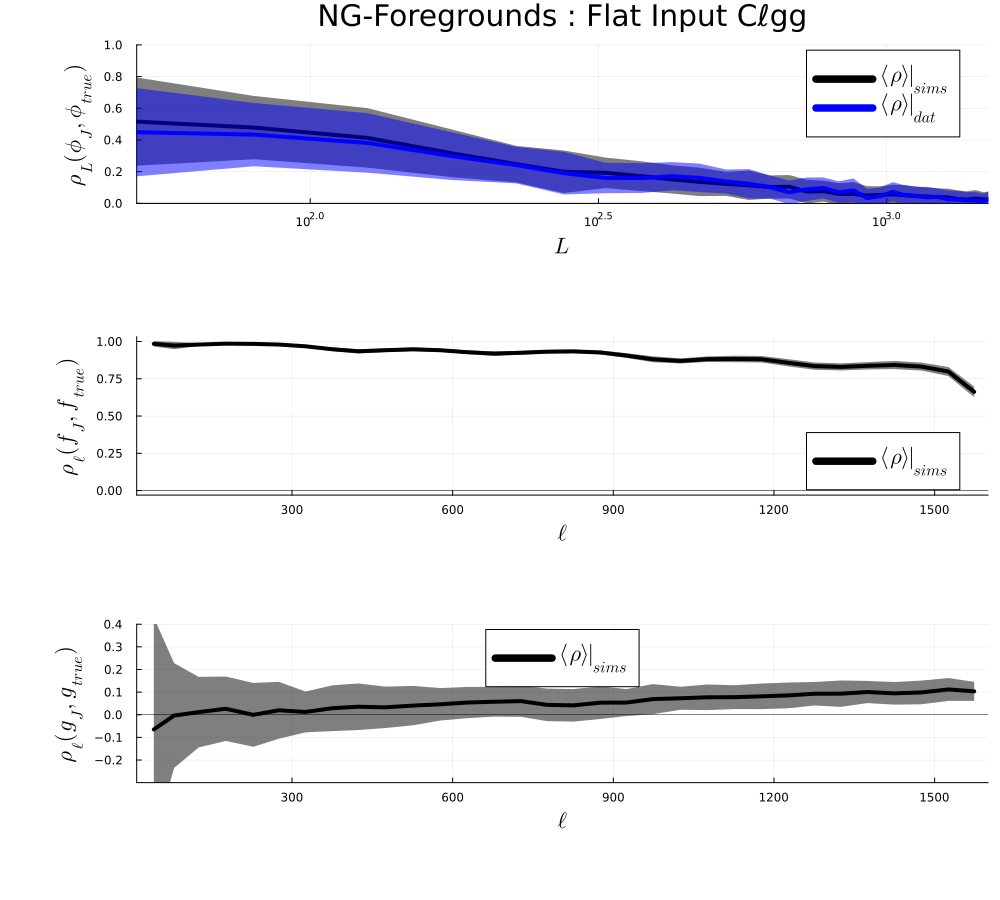

In [88]:
p1 = plot(xlims=(50,1500),title="Correlation coefficient\nInput Cℓg=Flat Cℓg at 'best fit' level",titlefontsize=20)#,xscale=:log10)
#p1 = plot(xlims=(50,1500),title="Correlation coefficient\nInput Cℓg=fg-only full-sky Cℓs",titlefontsize=20)#,xscale=:log10)
ylabel!(L"\rho_L(\phi_J, \phi_{true})")
hline!([0],c="black",lw=0.5,label="")
xlabel!(L"L")
xlims!(0,1000)
p2= plot(xlims=(10,MPF_max))
ylabel!(L"\rho_{\ell}(f_J, f_{true})")
hline!([0],c="black",lw=0.5,label="")
xlabel!(L"\ell")
xlims!(0,MPF_max)
p3= plot(xlims=(10,MPF_max))
ylabel!(L"\rho_{\ell}(g_J, g_{true})")
hline!([0],c="black",lw=0.5,label="")
xlabel!(L"\ell")
xlims!(0,MPF_max)

plot!(p1, Cℓs(Ls_sims, mean(ρϕs)), lw=4, c="black", ribbon = σ_ρϕs, label=L"\langle \rho \rangle|_{\rm{sims}}",legendfontsize=15)#,linealpha=0.1)#,seriesalpha=0.1)
plot!(p2, Cℓs(ℓs_f_sims, mean(ρfs)), lw=4, c="black", ribbon = σ_ρfs, label=L"\langle \rho \rangle|_{\rm{sims}}",legendfontsize=15)
plot!(p3, Cℓs(ℓs_g_sims, mean(ρgs)), lw=4, c="black", ribbon = σ_ρgs, label=L"\langle \rho \rangle|_{\rm{sims}}",legendfontsize=15)

plot!(p1, Cℓs(Ls_sims, mean(ρϕs_dat)), lw=4, c="blue", ribbon = σ_ρϕs_dat,  label=L"\langle \rho \rangle|_{\rm{dat}}")#,linealpha=0.1)#,seriesalpha=0.1)
plot!(p2, Cℓs(ℓs_f_dat, mean(ρfs_dat)), lw=4, c="blue", ribbon = σ_ρfs_dat, label=L"\langle \rho \rangle|_{\rm{dat}}")
plot!(p3, Cℓs(ℓs_f_dat, mean(ρgs_dat)), lw=4, c="blue", ribbon = σ_ρgs_dat, label=L"\langle \rho \rangle|_{\rm{dat}}",legend=:bottomright)

ylims!(p1,0,1)
ylims!(p3,-0.3,0.4)
p_main=plot(p1,p2,p3, 
    size=(1200,900),layout=(3,1), xguidefontsize=15,yguidefontsize=15,
        left_margin=10Plots.mm, bottom_margin=10Plots.mm)

# MUSE Scores 

In [ ]:
muse_scores = map(data_score_list,avg_sim_scores_list) do g_dat, g_sims
    g_dat .- g_sims
end
;

In [ ]:
p1 = plot(title="Aϕ : Muse Scores") ; hline!([0],  color="black",label="")
p2 = plot(title="AT : Muse Scores") ; hline!([0],  color="black",label="")
p3 = plot(title="Ag : Muse Scores") ; hline!([0],  color="black",label="")
map(muse_scores) do muse_score
    plot!(p1,muse_score.Aϕ,label="",lw=0.5)
    plot!(p2,muse_score.AT,label="",lw=0.5)
    #plot!(p3,muse_score.Ag,label="",lw=0.5)
end
plot!(p1,mean(muse_scores).Aϕ,label="",lw=4)
plot!(p2,mean(muse_scores).AT,label="",lw=4)
#plot!(p3,mean(muse_scores).Ag,label="",lw=4)

plot(p1,p2,p3, size=(1000,800))

# Jacobian

In [ ]:
# Jacobian
covariance_method = SimpleCovariance(corrected=true)
θ_labels = zero(θ₀) * zero(θ₀)'
J_list=[]
Hinv_list = map(sim_scores_list) do sim_scores
    J_i = cov(covariance_method, identity.(sim_scores)) .+ θ_labels
    push!(J_list, J_i)
    Jinv_approx = Diagonal(-1 ./ var(sim_scores))
end
#
p=plot(title=L"\frac{diag(J)^{-1}_i}{diag(J)^{-1}_1}")
for Hinv in Hinv_list
    plot!(-diag(Hinv) ./ (1 ./ diag(J_list[1])),label="" )
end
ϵ  = 0.5
ylims!(1-ϵ,1+ϵ)
#

In [ ]:
p1 = plot(title=L"\sqrt{diag(J(A_{\phi}))^{-1}}")
xlabel!(L"L")
p2 = plot(title=L"\sqrt{diag(J(A_{T}))^{-1}}")
xlabel!(L"\ell")
p3 = plot(title=L"\sqrt{diag(J(A_{g}))^{-1}}")
xlabel!(L"\ell")
lab = zero(θ₀)
map(J_list, 1:length(J_list)) do Ji, i
    sig_i = sqrt.(diag(inv(Ji))) .+ lab
    plot!(p1,ℓcenters_ϕ, sig_i.Aϕ , label="")
    plot!(p2,ℓcenters_T, sig_i.AT , label="")
    #plot!(p3,ℓcenters_g, sig_i.Ag , label="")
end

plot(p1,p2,p3, size=(950,600))

In [ ]:
n1 = 1
n2 = 30
p1 = heatmap(cpu(corrify(J_list[n1]).data), c=:balance,clims=(-1,1),title="J$n1")
p2 = heatmap(cpu(corrify(J_list[n2]).data), c=:balance,clims=(-1,1),title="J$n2")
plot(p1,p2,size=(950,400))

### $\langle J \rangle$

In [ ]:
θ_labels = zero(θ₀) * zero(θ₀)'

J_list_avg = map(sim_scores_list) do sim_scores
    cov(covariance_method, identity.(sim_scores)) 
end
#n1 = 1
#n2 = 9
#p1 = heatmap(cpu(corrify(J_list_avg[n1]).data), c=:balance,clims=(-1,1),title="J$n1")
#p2 = heatmap(cpu(corrify(J_list_avg[n2]).data), c=:balance,clims=(-1,1),title="J$n2")
#plot(p1,p2,size=(950,400))
J=J_list_avg =mean(J_list_avg ) .+ θ_labels
heatmap(cpu(corrify(J_list_avg).data), c=:balance,clims=(-1,1),title=L"\langle J \rangle")

### $\theta$ : Averaged over $N_{dat}$ MUSE estimates

In [ ]:
α = 0.7

θ_list = map(muse_scores, Hinv_list) do score, Hinv
    θ₀ .- Hinv*score
end

θ_avg = mean(θ_list)
;

## SEM ? 

Use one J,H for the $\theta$ errors, and compute the Standard Error on the Mean as 

1)
$$
\sigma(\langle \hat{\theta} \rangle) \simeq \frac{1}{diag(J)}\sqrt{ \frac{Var(g_{dat}) + Var(\langle g_{sim} \rangle)}{N_{estimates}}}
$$

or 2)

$$
\sigma(\langle \hat{\theta} \rangle) =  \sqrt{\frac{\rm{diag}(\Sigma_{MUSE})}{N_{estimates}} }
$$


where $\hat{\theta}$ is the muse parameter estimate, and for 1) we use $J$ as an approximation for the Hessian of $\rm{log}\mathcal{P}$ wrt $\theta$.

Option 1) should suffice for this one step MUSE estimate. Although would be interesting to get $H$ matrix for this problem.

For fill area, which shows 1$\sigma$ scatter of $one$  MUSE estimate, we ideally would want $\sqrt{\rm{diag}(\Sigma_{MUSE})}$, but we'll use $\sqrt{\rm{diag}(J^{-1}_{MUSE})}$ for now. Note that the $J$'s from every MUSE run look pretty much the same.

In [ ]:

lab =  zero(θ_avg) 
invJ_approx = Diagonal(1 ./var(sim_scores_list[1]))
err = invJ_approx*sqrt.(   (var(data_score_list)/length(data_score_list)) + var(avg_sim_scores_list)/length(avg_sim_scores_list)    ) .+ lab

err2 = sqrt.(diag(inv(J))/length(data_score_list)) .+ lab

#
p1 = plot()#title=L"\frac{1}{diag(J)}\sqrt{ \frac{Var(g_{dat})}{N_{dat}} + \frac{Var(g_{sim})}{N_{sim}}}  vs  \sqrt{\frac{1}{\rm{diag}(J)N_{estimates}} }")
plot!(err.Aϕ, label=L"\frac{1}{diag(J)}\sqrt{ \frac{Var(g_{dat}) + Var(\langle g_{sim} \rangle)}{N_{estimates}}}")
plot!(err2.Aϕ, label=L"\sqrt{\frac{1}{\rm{diag}(J)N_{estimates}} }",c=1, ls=:dash)



In [49]:
fill_area = sqrt.(diag(inv(J))) .+ lab;
#fill_area =  sqrt.(1 ./var(sim_scores_list[1])).+ lab;

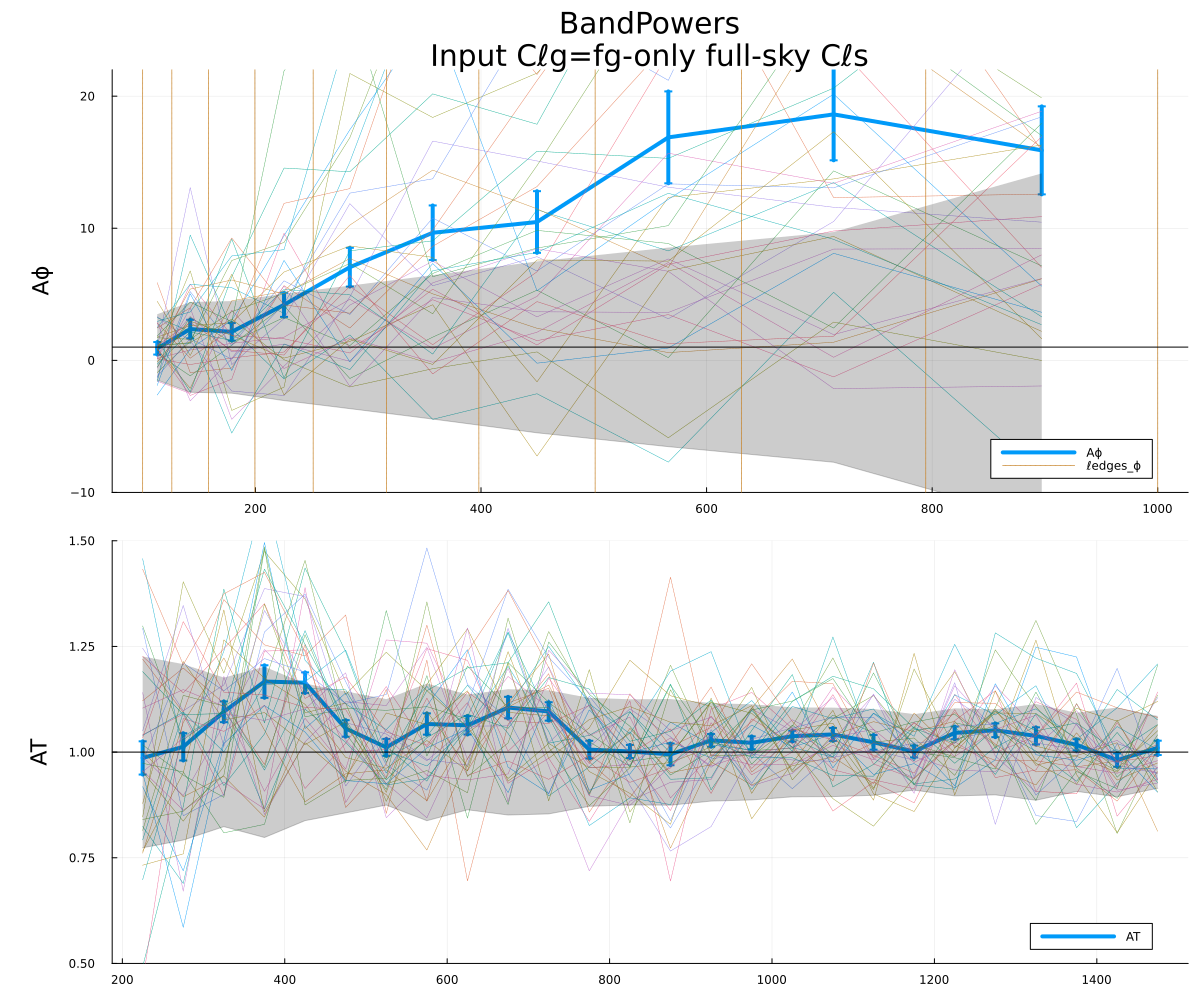

In [53]:
#p1 = plot(title="BandPowers\nInput Cℓg=Flat Cℓg at 'best fit' level",titlefontsize=20)#,xscale=:log10)
p1 = plot(title="BandPowers\nInput Cℓg=fg-only full-sky Cℓs",titlefontsize=20)#,xscale=:log10)

ylabel!("Aϕ")
plot!(ℓcenters_ϕ, θ_avg.Aϕ, yerr=err.Aϕ,msc=:auto, label="Aϕ",lw=4)#, c="red")
map(θ_list) do θ_i
    plot!(ℓcenters_ϕ,θ_i.Aϕ,label="",lw=0.5,ls=:dot)
end
plot!(ℓcenters_ϕ, 1 .- fill_area.Aϕ, fillrange = 1 .+ fill_area.Aϕ, c=:black, alpha=0.2, label="")
vline!(ℓedges_ϕ,label="ℓedges_ϕ",lw=0.8,ls=:dot)
hline!([1],  color="black",label="")
ylims!(-10,22)

p2 = plot()
ylabel!("AT")
plot!(ℓcenters_T,θ_avg.AT, yerr=err.AT,msc=:auto, label="AT",lw=4)#, c="red")
map(θ_list) do θ_i
    plot!(ℓcenters_T,θ_i.AT,label="",lw=0.5,ls=:dot)
end
plot!(ℓcenters_T, 1 .- fill_area.AT, fillrange = 1 .+ fill_area.AT, c=:black, alpha=0.2, label="")
hline!([1],  color="black",label="")
ylims!(0.5,1.5)

p3 = plot()
ylabel!("Ag")
#plot!(ℓcenters_g,θ_avg.Ag, yerr=err.Ag,msc=:auto, label="Ag",lw=4)#, c="red")
#map(θ_list) do θ_i
#    plot!(ℓcenters_g,θ_i.Ag,label="",lw=0.5,ls=:dot)
#end
#plot!(ℓcenters_g, 1 .- fill_area.Ag, fillrange = 1 .+ fill_area.Ag, c=:black, alpha=0.2, label="")
hline!([1],  color="black",label="")
ylims!(-1000,1000)

plot(p1,p2,#p3, 
    size=(1200,1000), layout=(2,1), xguidefontsize=15,yguidefontsize=15,
    left_margin=10Plots.mm)



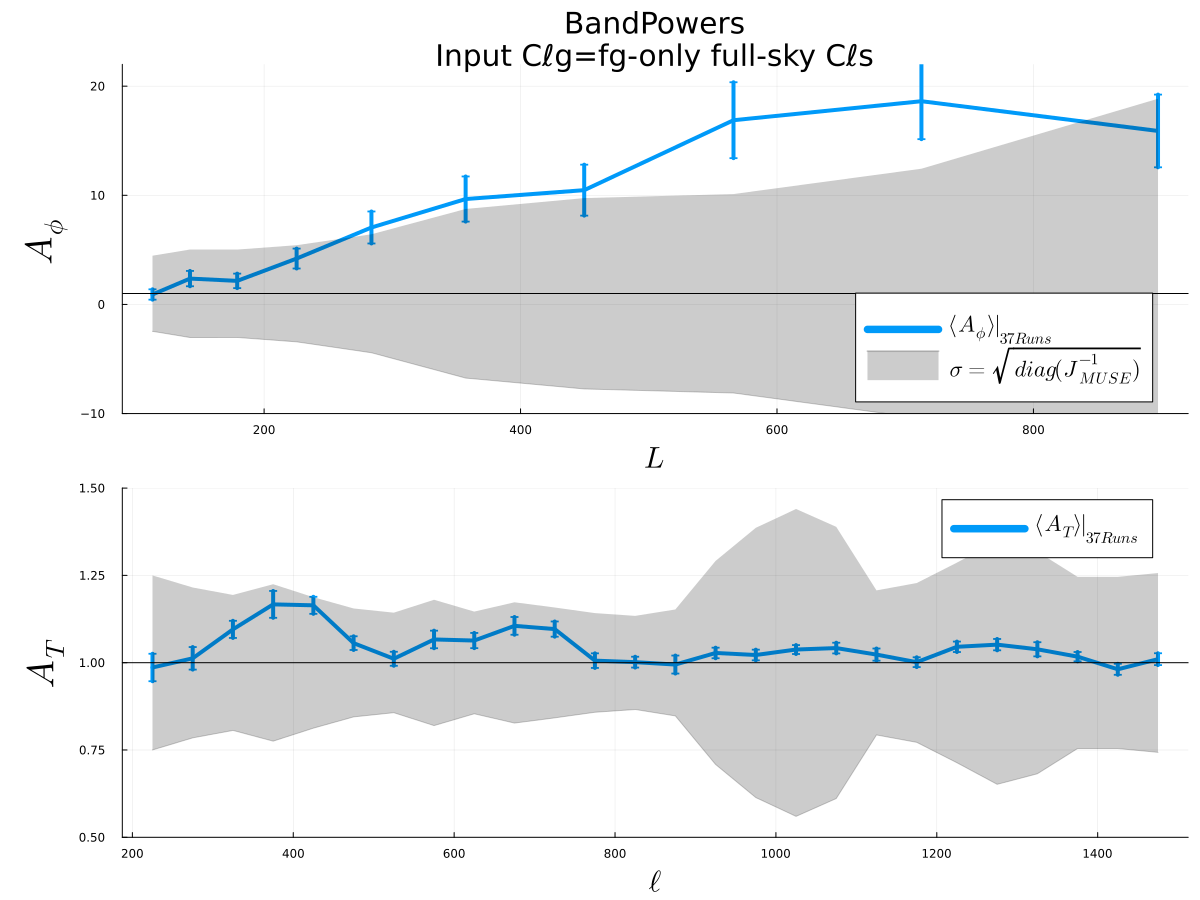

In [442]:


#p1 = plot(title="BandPowers\nInput Cℓg=Flat Cℓg at 'best fit' level",titlefontsize=20,legend=:topleft,legendfontsize=15)#,xscale=:log10)
p1 = plot(title="BandPowers\nInput Cℓg=fg-only full-sky Cℓs",titlefontsize=20,legend=:bottomright,legendfontsize=15)#,xscale=:log10)legend=:topleft)
ylabel!(L"A_{\phi}")

plot!(ℓcenters_ϕ, θ_avg.Aϕ, yerr=err.Aϕ,msc=:auto, label=L"\langle A_{\phi} \rangle|_{37 Runs}",lw=4)#, c="red")
#map(θ_list) do θ_i
#    plot!(ℓcenters_ϕ,θ_i.Aϕ,label="",lw=0.5,ls=:dot)
#end
plot!(ℓcenters_ϕ, 1 .- fill_area.Aϕ, fillrange = 1 .+ fill_area.Aϕ, c=:black, alpha=0.2, label=L"\sigma = \sqrt{\rm{diag}(J^{-1}_{MUSE})}")
#vline!(ℓedges_ϕ,label="ℓedges_ϕ",lw=0.8,ls=:dot)
xlabel!(L"L")
hline!([1],  color="black",label="")
ylims!(-10,22)

p2 = plot(legendfontsize=15)
ylabel!(L"A_{T}")
plot!(ℓcenters_T,θ_avg.AT, yerr=err.AT,msc=:auto,label=L"\langle A_{T} \rangle|_{37 Runs}",lw=4)#, c="red")
#map(θ_list) do θ_i
#    plot!(ℓcenters_T,θ_i.AT,label="",lw=0.5,ls=:dot)
#end
plot!(ℓcenters_T, 1 .- fill_area.AT, fillrange = 1 .+ fill_area.AT, c=:black, alpha=0.2, label="")
hline!([1],  color="black",label="")
ylims!(0.5,1.5)
xlabel!(L"\ell")


p3 = plot()
ylabel!(L"A_{g}")
plot!(ℓcenters_g,θ_avg.Ag, yerr=err.Ag,msc=:auto, label=L"\langle A_{g} \rangle|_{37 Runs}",lw=4)#, c="red")
#map(θ_list) do θ_i
#    plot!(ℓcenters_g,θ_i.Ag,label="",lw=0.5,ls=:dot)
#end
plot!(ℓcenters_g, 1 .- fill_area.Ag, fillrange = 1 .+ fill_area.Ag, c=:black, alpha=0.2, label="")
hline!([1],  color="black",label="")
ylims!(-100,100)

ptot=plot(p1,p2,#p3, 
    size=(1200,900), layout=(2,1), xguidefontsize=20,yguidefontsize=25,
    left_margin=10Plots.mm)

### Save Scores and such

In [122]:
# save ILC results
save_object("approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/ilc_results/muse_score_list_ilc.jld2",cpu(muse_scores))
save_object("approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/ilc_results/data_score_list_ilc.jld2",cpu(data_score_list))
save_object("approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/ilc_results/sim_scores_list_ilc.jld2",cpu(sim_scores_list))
save_object("approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/ilc_results/avg_sim_scores_list_ilc.jld2",cpu(avg_sim_scores_list))
save_object("approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/ilc_results/J_list_ilc.jld2",cpu(J_list))
save_object("approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/ilc_results/θ_list.jld2",cpu(θ_list))


In [23]:
# load ILC results
muse_scores = load_object("approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/ilc_results/muse_score_list_ilc.jld2")
data_score_list = load_object("approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/ilc_results/data_score_list_ilc.jld2")
sim_scores_list = load_object("approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/ilc_results/sim_scores_list_ilc.jld2")
avg_sim_scores_list = load_object("approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/ilc_results/avg_sim_scores_list_ilc.jld2")
J = load_object("approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/ilc_results/J_ilc.jld2")
θ_list = load_object("approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/ilc_results/θ_list.jld2")
;

## get_H!

In [136]:
result = MuseResult()
result.θ = θ₀
result.gs = sim_scores
# Jacobian
covariance_method = SimpleCovariance(corrected=true)
θ_labels = zero(θ₀) * zero(θ₀)'
result.J = cov(covariance_method, identity.(result.gs)) .+ θ_labels
result.H = nothing
result.Hs = []
result.dist = nothing
result.Σ = result.Σ⁻¹ = nothing
result.rng = nothing
result.time = MuseInference.Millisecond(0)
prob = CMBLensingMuseProblem(ds; MAP_joint_kwargs=(;progress=false,delete(MAP_joint_kwargs, :progress)...) )
temp = simulate(MersenneTwister(1), ds)
z₀ = zero(FieldTuple(;f=temp.f, ϕ=temp.ϕ, g=temp.g) );


In [ ]:
dir="approx_muse_maps/run"*string(RUN_NUMBER)*"/unbeamed/"
#save_object(dir*"muse_result.jld2",result)
result=load_object(dir*"muse_result.jld2")

MuseResult((Aϕ = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], AT = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [ ]:
get_H!(result, prob, θ₀;
    fdm = MuseInference.central_fdm(3,1),
    rng = MersenneTwister(42),
    nsims = 10, 
    step = 0.1 ./ std(result.gs), 
    pool,
    pmap_over = :jac,
    progress = true,
    z₀
)

get_H:  19%|████████▍                                   |  ETA: 13:51:48

In [ ]:
map(result.Hs,length(result.Hs)) do Hi, i
    save_object(dir*"Hs/H"*string(i)*".jld2",cpu(Hi))
end

In [ ]:
save_object(dir*"Hs/H10.jld2",cpu(result.H))